# <img src="./assets/course-icon.png" style="height:50px;display:inline"> Learning Methods of Deep Learning
---

create by Deepfinder



### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---

1. 师徒相授：有监督学习（Supervised Learning）
2. **见微知著：无监督学习（Un-supervised Learning）**
3. 无师自通：自监督学习（Self-supervised Learning）
4. 以点带面：半监督学习（Semi-supervised learning）
5. 明辨是非：对比学习（Contrastive Learning）
6. 举一反三：迁移学习（Transfer Learning）
7. 针锋相对：对抗学习（Adversarial Learning）
8. 众志成城：集成学习(Ensemble Learning) 
9. 殊途同归：联邦学习（Federated Learning）
10. 百折不挠：强化学习（Reinforcement Learning）
11. 求知若渴：主动学习（Active Learning）
12. 万法归宗：元学习（Meta-Learning）


## Tutorial 02 - 见微知著：无监督学习（Un-supervised Learning） 

### <img src="https://img.icons8.com/color/96/000000/code.png" style="height:50px;display:inline"> 自编码器 Auto-encoders
---

* 大多数自然数据都是高维的，例如图像。考虑 MNIST（手写数字）数据集，其中每幅图像有 $28x28=784$ 个像素，这意味着它可以用长度为 784 的向量表示。
* 但我们真的需要 784 个值来表示一个数字吗？答案是否定的。我们认为数据位于低维空间中，足以描述观察结果。在 MNIST 的情况下，我们可以选择将数字表示为独热向量，这意味着我们只需要 10 个维度。因此，我们可以在低维空间中**编码**高维观察结果。

#### <img src="https://img.icons8.com/?size=100&id=91CnU00i6HLv&format=png&color=000000" style="height:50px;display:inline"> 但我们如何才能学习有意义的低维表示？

一般的想法是重建或**解码**低维表示为高维表示，并使用重建误差来找到最佳表示（使用误差的梯度）。这是**自动编码器**背后的核心思想。
* **自动编码器** - 将数据作为输入并发现该数据的一些潜在状态表示的模型。输入数据被转换为编码向量，其中每个维度代表有关数据的一些学习属性。这里要掌握的最重要的细节是我们的编码器网络为每个编码维度输出一个值。然后，解码器网络随后获取这些值并尝试重新创建原始输入。
* 自动编码器有**三个部分**：编码器、解码器和将一个部分映射到另一个部分的“损失”函数。对于最简单的自动编码器（即压缩然后从压缩表示中重建原始输入的那种），我们可以将“损失”视为描述重建过程中丢失的信息量。

<center><img src="./assets/tut_xv_autoencoder.png" style="height:250px">
        

<center><img src="./assets/tut_xiv_autoencoder.png" style="height:250px">

 <a href="https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798">Image Source</a>
    
Let's implement it in PyTorch using what we have learnt so far!

shape: 
 torch.Size([64, 1, 28, 28])


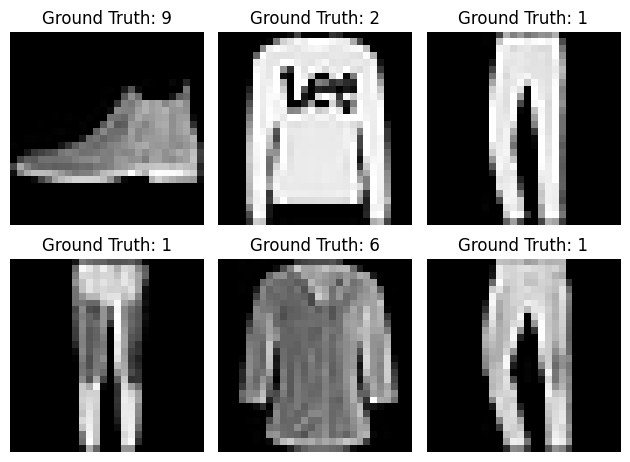

In [3]:
import torch
import torch.nn as nn 
import torchvision 
import matplotlib.pyplot as plt
import time
# Fashion-MNIST
fmnist_train_dataset = torchvision.datasets.FashionMNIST(root='./datasets/',
                                           train=True, 
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)

fmnist_test_dataset = torchvision.datasets.FashionMNIST(root='./datasets',
                                          train=False, 
                                          transform=torchvision.transforms.ToTensor())

# Data loader
fmnist_train_loader = torch.utils.data.DataLoader(dataset=fmnist_train_dataset,
                                           batch_size=64, 
                                           shuffle=True, drop_last=True)

fmnist_test_loader = torch.utils.data.DataLoader(dataset=fmnist_test_dataset,
                                          batch_size=64, 
                                          shuffle=False)

# let's plot some of the samples from the test set
examples = enumerate(fmnist_test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print("shape: \n", example_data.shape)
fig = plt.figure()
for i in range(6):
    ax = fig.add_subplot(2,3,i+1)
    ax.imshow(example_data[i][0], cmap='gray', interpolation='none')
    ax.set_title("Ground Truth: {}".format(example_targets[i]))
    ax.set_axis_off()
plt.tight_layout()

In [4]:
class AutoEncoder(nn.Module):
    
    def __init__(self, input_dim=28*28, hidden_dim=256, latent_dim=10):
        super(AutoEncoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # define the encoder
        self.encoder = nn.Sequential(nn.Linear(self.input_dim, self.hidden_dim),
                                     nn.ReLU(), 
                                     nn.Linear(self.hidden_dim, self.hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_dim, self.latent_dim)
                                    )
        
        # define decoder
        self.decoder = nn.Sequential(nn.Linear(self.latent_dim, self.hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_dim, self.hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_dim, self.input_dim),
                                     nn.Sigmoid())
        
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def get_latent_rep(self, x):
        return self.encoder(x)

In [5]:
# hyper-parameters:
num_epochs = 5
learning_rate = 0.001

# Device configuration, as before
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# create model, send it to device
model = AutoEncoder(input_dim=28 * 28, hidden_dim=128, latent_dim=10).to(device)

# Loss and optimizer
criterion = nn.BCELoss()  # binary cross entropy, as pixels are in [0,1]
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# Train the model
total_step = len(fmnist_train_loader)
start_time = time.time()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(fmnist_train_loader): 
        images = images.to(device).view(64, -1)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)
        
        # Backward and optimize - ALWAYS IN THIS ORDER!
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Time: {:.4f} secs' 
                   .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), time.time() - start_time))

Epoch [1/5], Step [100/937], Loss: 0.3769, Time: 0.4937 secs
Epoch [1/5], Step [200/937], Loss: 0.3284, Time: 0.7780 secs
Epoch [1/5], Step [300/937], Loss: 0.3262, Time: 1.0713 secs
Epoch [1/5], Step [400/937], Loss: 0.3260, Time: 1.3613 secs
Epoch [1/5], Step [500/937], Loss: 0.3224, Time: 1.6620 secs
Epoch [1/5], Step [600/937], Loss: 0.3147, Time: 1.9529 secs
Epoch [1/5], Step [700/937], Loss: 0.3029, Time: 2.2464 secs
Epoch [1/5], Step [800/937], Loss: 0.3255, Time: 2.5387 secs
Epoch [1/5], Step [900/937], Loss: 0.3377, Time: 2.8275 secs
Epoch [2/5], Step [100/937], Loss: 0.3174, Time: 3.2292 secs
Epoch [2/5], Step [200/937], Loss: 0.3075, Time: 3.5164 secs
Epoch [2/5], Step [300/937], Loss: 0.3102, Time: 3.8110 secs
Epoch [2/5], Step [400/937], Loss: 0.2994, Time: 4.0883 secs
Epoch [2/5], Step [500/937], Loss: 0.3047, Time: 4.3774 secs
Epoch [2/5], Step [600/937], Loss: 0.2948, Time: 4.6684 secs
Epoch [2/5], Step [700/937], Loss: 0.2991, Time: 4.9575 secs
Epoch [2/5], Step [800/9

shape: 
 torch.Size([64, 1, 28, 28])


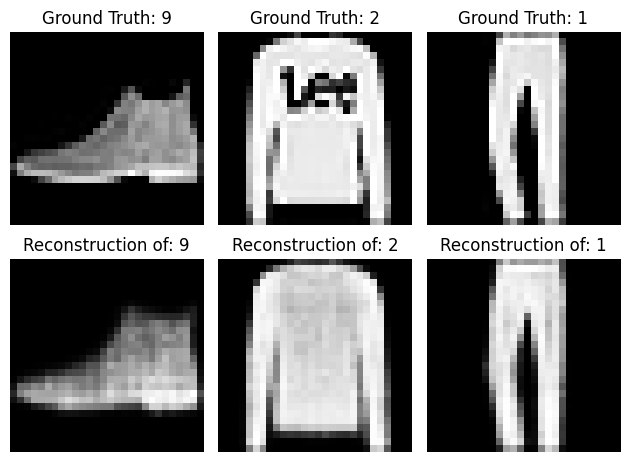

In [8]:
# let's see some of the reconstructions
model.eval()  # put in evaluation mode - no gradients
examples = enumerate(fmnist_test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print("shape: \n", example_data.shape)
fig = plt.figure()
for i in range(3):
    ax = fig.add_subplot(2,3,i+1)
    ax.imshow(example_data[i][0], cmap='gray', interpolation='none')
    ax.set_title("Ground Truth: {}".format(example_targets[i]))
    ax.set_axis_off()
    
    ax = fig.add_subplot(2,3,i+4)
    recon_img = model(example_data[i][0].view(1, -1).to(device)).data.cpu().numpy().reshape(28, 28)
    ax.imshow(recon_img, cmap='gray')
    ax.set_title("Reconstruction of: {}".format(example_targets[i]))
    ax.set_axis_off()
plt.tight_layout()

In [9]:
# let's compare different dimensionality reduction methods
n_neighbors = 10
n_components = 2
n_points = 500

fmnist_test_loader = torch.utils.data.DataLoader(dataset=fmnist_test_dataset,
                                          batch_size=n_points, 
                                          shuffle=False)
X, labels = next(iter(fmnist_test_loader))
latent_X = model.get_latent_rep(X.to(device).view(n_points, -1)).data.cpu().numpy()
labels = labels.data.cpu().numpy()

PCA time: 0.0079 sec
KPCA time: 0.023 sec
t-SNE time: 0.39 sec


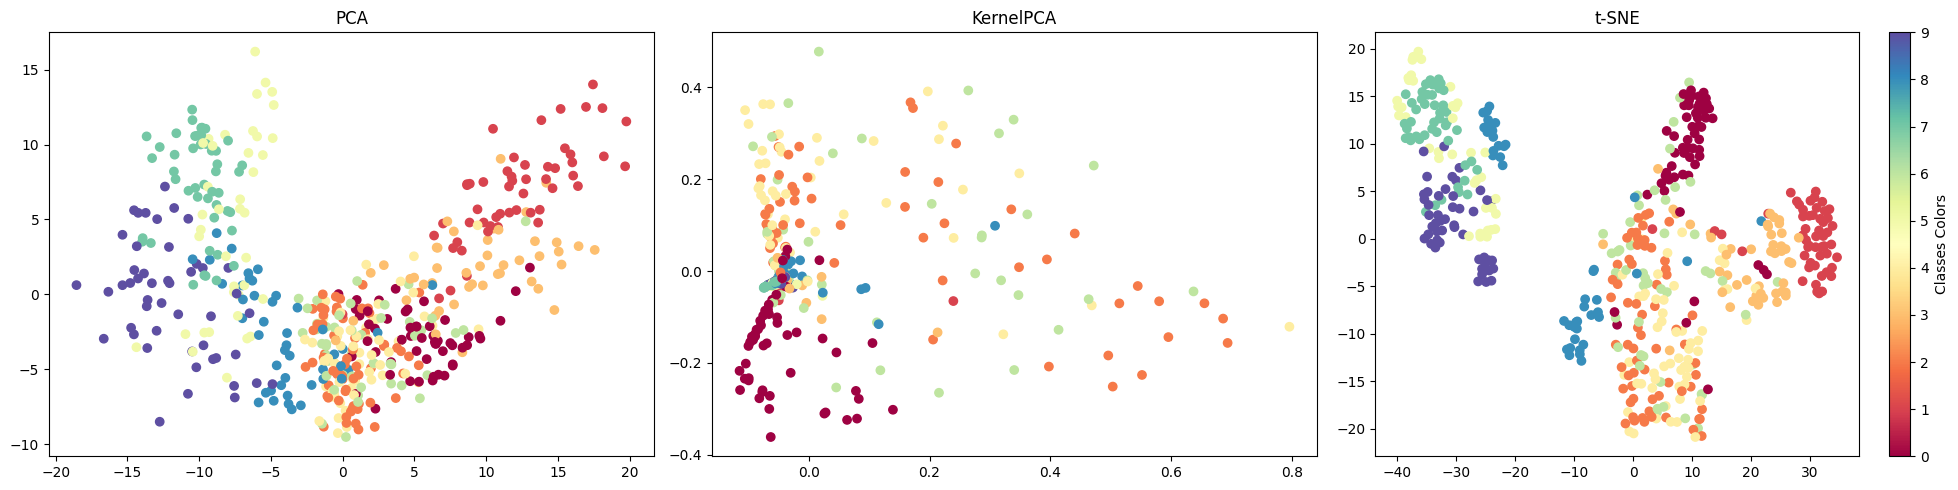

In [10]:
# scikit-learn imports
from sklearn.manifold import LocallyLinearEmbedding, Isomap, TSNE
from sklearn.decomposition import PCA, KernelPCA
import numpy as np

fig = plt.figure(figsize=(20,5))

# PCA
t0 = time.time()
x_pca = PCA(n_components).fit_transform(latent_X)
t1 = time.time()
print("PCA time: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(1, 3, 1)
ax.scatter(x_pca[:, 0], x_pca[:, 1], c=labels, cmap=plt.cm.Spectral)
ax.set_title('PCA')

# KPCA
t0 = time.time()
x_kpca = KernelPCA(n_components, kernel='rbf').fit_transform(latent_X)
t1 = time.time()
print("KPCA time: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(1, 3, 2)
ax.scatter(x_kpca[:, 0], x_kpca[:, 1], c=labels, cmap=plt.cm.Spectral)
ax.set_title('KernelPCA')



# t-SNE
t0 = time.time()
x_tsne = TSNE(n_components).fit_transform(latent_X)
t1 = time.time()
print("t-SNE time: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(1, 3, 3)
scatter = ax.scatter(x_tsne[:, 0], x_tsne[:, 1], c=labels, cmap=plt.cm.Spectral)
ax.set_title('t-SNE')

bounds = np.linspace(0, 10, 11)
cb = plt.colorbar(scatter, spacing='proportional',ticks=bounds)
cb.set_label('Classes Colors')

plt.tight_layout()

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---
* Icons made by <a href="https://www.flaticon.com/authors/becris" title="Becris">Becris</a> from <a href="https://www.flaticon.com/" title="Flaticon">www.flaticon.com</a>
* Icons from <a href="https://icons8.com/">Icons8.com</a> - https://icons8.com
* Datasets from <a href="https://www.kaggle.com/">Kaggle</a> - https://www.kaggle.com/
* <a href="https://machinelearningmastery.com/why-initialize-a-neural-network-with-random-weights/">Jason Brownlee - Why Initialize a Neural Network with Random Weights?</a>
* <a href="https://openai.com/blog/deep-double-descent/">OpenAI - Deep Double Descent</a>
* <a href="https://taldatech.github.io">Tal Daniel</a>